기본 환경설정

In [8]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname =  'C:/Windows/Fonts/malgun.ttf').get_name()
matplotlib.rc('font', family = font_name)

seoul_area = gpd.GeoDataFrame.from_file('LARD_ADM_SECT_SGG_11.shp', encoding='cp949')
pt_119 = pd.read_csv('서울시 안전센터관할 위치정보 (좌표계_ WGS1984).csv', encoding='cp949', dtype=str)
pt_119['경도'] = pt_119['경도'].astype(float)
pt_119['위도'] = pt_119['위도'].astype(float)
pt_119['geometry'] = pt_119.apply(lambda row: Point([row['경도'], row['위도']]), axis=1)
pt_119 = gpd.GeoDataFrame(pt_119, geometry='geometry')
pt_119.crs = {'init':'epsg:4326'}
pt_119 = pt_119.to_crs({'init':'epsg:5179'})

C:\Users\Jun\anaconda3\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [10]:
seoul_area.head()

,ADM_SECT_C,SGG_NM,SGG_OID,COL_ADM_SE,GID,geometry
0,11740,강동구,337,11740,127,"POLYGON ((969713.132 1948846.288, 969692.451 1..."
1,11710,송파구,1969,11710,128,"POLYGON ((968640.372 1944982.492, 968640.957 1..."
2,11680,강남구,33,11680,129,"POLYGON ((958696.114 1948605.678, 959195.920 1..."
3,11650,서초구,33,11650,130,"POLYGON ((958117.753 1940073.855, 958118.398 1..."
4,11620,관악구,33,11620,131,"POLYGON ((949321.250 1944035.054, 949323.256 1..."


# 1. 객체 속성
1. `area`: 면적 계산
2. `length`: 길이 계산
3. `boundary`: 테두리(LineString 객체)
4. `exterior`: 테두리(LinearRing 객체)
5. `centroid`: 무게중심점
6. `xy`: 좌표 반환(array, tuple 객체)
7. `coords`: 좌표 반환(shapely.coords 객체)
8. `is_valid`: 도형 유효성 검사(boolean)
9. `geom_type`: 공간 객체 타입

## 1_1 area

In [9]:
# area
seoul_area.geometry.area.head()

0    2.453758e+07
1    3.383061e+07
2    3.946631e+07
3    4.685083e+07
4    2.954112e+07
dtype: float64

## 1_2 length
- ploygon의 `length`는 테두리의 길이(둘레)가 될 것이다.

In [11]:
# length
seoul_area.geometry.length.head()

0    24029.227412
1    30532.219899
2    35504.681042
3    43978.564653
4    27448.698426
dtype: float64

## 1_3 boundary
- `boundary`는 Polygon 객체의 테두리로 `LineString`객체를 반환한다.

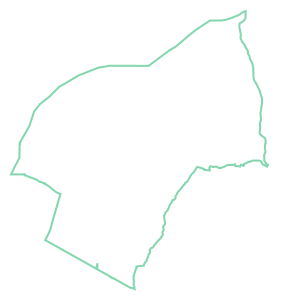

In [14]:
# boundary
seoul_area.geometry[0].boundary

## 1_4 centroid
- `centroid`는 다각형의 무게중심점으로 중학교 수학시간에 배웠던 것과 같다.

In [15]:
seoul_area.geometry.centroid.head()

0    POINT (968820.295 1950182.074)
1    POINT (965998.688 1945219.460)
2    POINT (961369.995 1944245.952)
3    POINT (958548.929 1941666.568)
4    POINT (950951.582 1941050.947)
dtype: geometry

## 1_5. xy와 coords
- `xy`와 `coords`는 사실 shaply의 공간 객체인 `Point`와 `LineString`의 속성이기 때문에 `GeoDataFrame`과 `GeoSeries`에 바로 적용할 수 없다.  
- 또한 Ploygon의 좌표를 뽑기 위해선 `boundary`로 Line객체를 만들고 속성을 뽑아야 한다.

In [16]:
# xy와 coords
print(pt_119['geometry'][0].xy)
print(pt_119['geometry'][0].coords)
print(list(pt_119['geometry'][0].coords))

(array('d', [944285.7077635808]), array('d', [1947726.3905374545]))
[(944285.7077635808, 1947726.3905374545)]


## 1_6. is_valid
- `is_valid`는 도형이 유효한지를 검사할 때 사용한다.
- 공간데이터는 좌표나 제작 출처에 따라서 조금씩 모양이 다르기도 하고, 삐져나오거나 마감처리가 잘 안되어 있거나 한 경우가 있는데 처리하지 않으면 에러가 난다.
- 아래의 경우 index1의 객체가 유효하지 않다고 나와있다.

In [17]:
# is_valid
seoul_area.geometry.is_valid.head()

0     True
1    False
2     True
3     True
4     True
dtype: bool

# 2. 공간 관계
1. `within`: 포함되는지 여부
2. `contain`: 포함하고 있는지 여부
3. `intersects`: 교차하는지 여부(경계에 닿아있기만 해도 됨)
4. `crosses`: 교차하는지 여부(내부를 지나가야 함)
5. `distance`: 두 공간 사이의 직선(최단)거리를 계산한다.

## 2_1.within과 contain

In [18]:
seoul_area.head(3)

,ADM_SECT_C,SGG_NM,SGG_OID,COL_ADM_SE,GID,geometry
0,11740,강동구,337,11740,127,"POLYGON ((969713.132 1948846.288, 969692.451 1..."
1,11710,송파구,1969,11710,128,"POLYGON ((968640.372 1944982.492, 968640.957 1..."
2,11680,강남구,33,11680,129,"POLYGON ((958696.114 1948605.678, 959195.920 1..."


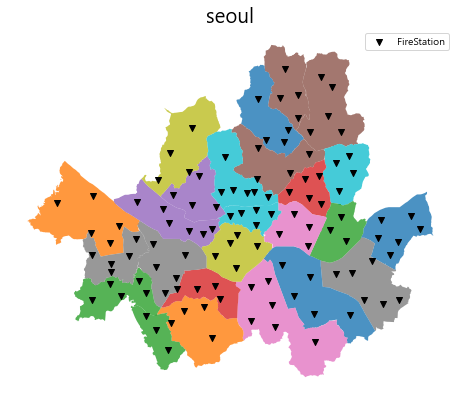

In [22]:
ax = seoul_area.plot(column = 'SGG_NM', figsize=(8, 8), alpha=0.8)
pt_119.plot(ax=ax, marker='v', color='black', label='FireStation')
ax.set_title('seoul', fontsize=20)
ax.set_axis_off()
plt.legend()
plt.show()

`within`과 `contains`는 어법이 반대인 것만 빼면 같은 함수라 할 수 있고 같은 결과를 반환한다.

In [24]:
# 고덕 119안전센터는 강동구 안에 있다.
print(pt_119.geometry[17].within(seoul_area.geometry[0]))

# 강동구 안에는 고덕 119안전센터가 있다.
print(seoul_area.geometry[0].contains(pt_119.geometry[17]))

True
True
